# Q-Alpha

In [1]:
# # configs

# {
#     "API_settings": {
#         "snowflake_parameters": {
#             "user": "tim.bastian@tcw.com",
#             "password": "fd*@emJpu@uCorH6"
#         }
#     },
#     "default_weights_constraint": [0.001, 0.15],
#     "weight_constraint": {
#         "SPXT Index": [0, 0.3],
#         "XNDX Index": [0, 0.2],
#         "GA10 Index": [0, 0.5],
#         "LUMSTRUU Index": [0, 0.5],
#         "DJUSRET Index": [0, 0.08],
#         "BCOMTR Index": [0, 0.08],
#         "GC1 Comdty": [0, 0.1]
#     },
#     "allocation_limit": {
#         "limited_assets": ["SPXT Index", "XNDX Index", "DJUSRET Index", "BCOMTR Index", "GC1 Comdty"],
#         "limit": 0.28,
#         "allocate_to": ["LUMSTRUU Index", "GA10 Index"]
#     },
#     "trans_cost": 0.01,
#     "portfolio_datasource": {
#         "source": 1,
#         "file": "C:\\Users\\bastit\\OneDrive - The TCW Group Inc\\Documents\\quantkit\\Q_Alpha_Output\\Q_Alpha_historical_weights.xlsx",
#         "sheet_name": "Sheet1",
#         "start_date": "01/01/2000",
#         "end_date": "12/29/2023",
#         "custom_universe": ["LUMSTRUU Index", "GA10 Index", "SPXT Index", "XNDX Index", "DJUSRET Index", "BCOMTR Index", "GC1 Comdty"],
#         "equity_universe": [],
#         "fixed_income_universe": [],
#         "tcw_universe": [],
#         "sustainable": false
#     },
#     "marketmultiple_datasource": {
#         "filters": {
#             "start_date": "1999-01-01"
#         }
#     },
#     "prices_datasource": {
#         "rebalance": "MONTH",
#         "source": 9,
#         "fields": ["PX_LAST"],
#         "tickers": ["SPXT Index", "XNDX Index", "GA10 Index", "LUMSTRUU Index", "DJUSRET Index", "BCOMTR Index", "GC1 Comdty"],
#         "start_date": "2010-01-01",
#         "end_date": "2024-04-05",
#         "filters": {
#             "ca_adj": "FULL"
#         }
#     },
#     "fundamentals_datasource": {
#         "source": 3,
#         "filters": {
#             "calendardate": {"start_date": "1999-01-01"}
#         },
#         "table_name": "FUNDAMENTALS_QALPHA",
#         "database": "SANDBOX_ESG",
#         "schema": "QUANT_RESEARCH"
#     },
#     "strategies": {
#         "q_alpha": {
#             "type": "pick_all",
#             "stop_loss": null,
#             "stop_loss_threshold": 0.1,
#             "portfolio_leverage": 5,
#             "window_size": 63,
#             "return_engine": "log_normal",
#             "risk_engine": "log_normal",
#             "allocation_models": ["equal_weight", "hrp", "constrained_hrp", "scaled_hrp", "original_weight"]
#         }
#     }
# }

In [2]:
# add quantkit to path
import sys
from pathlib import Path

d = Path().resolve().parent.parent
sys.path.insert(0, str(d))

In [3]:
import pandas as pd
import numpy as np
import quantkit.backtester.runner_backtester as runner
import warnings

warnings.filterwarnings("ignore")

local_configs = "C:\\Users\\bastit\\OneDrive - The TCW Group Inc\\Documents\\quantkit\\configs\\configs_q_alpha.json"

r = runner.Runner()
r.init(local_configs=local_configs)
r.run()

2024-06-04 15:53:55,254  WORKING ON: Start Iterating
2024-06-04 15:53:55,255  WORKING ON: Loading Portfolio Data


KeyError: 'DATE'

## 1. Q-Alpha Index Returns

In [ ]:
df = r.strategies["q_alpha"].all_portfolios.dropna()
# df = df[df["portfolio_name"] == "ex_ante_hrp"]
df = df[df.index > "2019-12-01"]

<Figure size 640x480 with 0 Axes>

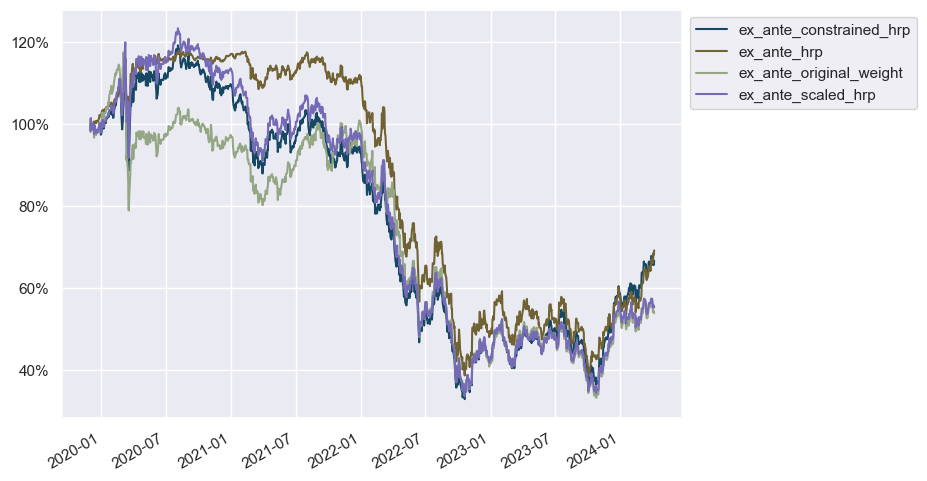

In [ ]:
import quantkit.visualization.asset_allocation.returns as returns

return_df = r.strategies["q_alpha"].all_portfolios

returns.strategy_returns(df, excluded_allocations=["ex_ante_equal_weight"])

## 2. Allocation

### 2.1 Unconstrained HRP

In [ ]:
unconstrained_df = pd.DataFrame(columns=r.portfolio_datasource.all_tickers)
for date, allo in (
    r.strategies["q_alpha"].allocation_engines_d["hrp"].allocations_history.items()
):
    unconstrained_df = pd.concat(
        [
            unconstrained_df,
            pd.DataFrame(
                allo, columns=[date], index=r.portfolio_datasource.all_tickers
            ).transpose(),
        ]
    )

qalpha_cols = {
    "SPXT Index": "SP500",
    "XNDX Index": "Nasdaq",
    "GA10 Index": "Treasuries",
    "LUMSTRUU Index": "MBSIdx",
    "DJUSRET Index": "REITs",
    "BCOMTR Index": "Commodities",
    "GC1 Comdty": "Gold",
}
unconstrained_df = unconstrained_df.rename(columns=qalpha_cols)

unconstrained_df.tail()

,Commodities,Gold,MBSIdx,Nasdaq,REITs,SP500,Treasuries
2023-12-31,0.882247,0.747154,1.196947,0.498974,0.144441,0.820588,0.709649
2024-01-31,0.749299,0.628461,1.390905,0.438608,0.152777,0.817599,0.822351
2024-02-29,0.974105,0.949049,0.972312,0.528375,0.208060,0.582210,0.785890
2024-03-31,1.121974,0.866842,0.996396,0.433225,0.233096,0.503204,0.845264
2024-04-05,1.178000,0.698072,1.080797,0.391759,0.248473,0.525099,0.877801


<Figure size 640x480 with 0 Axes>

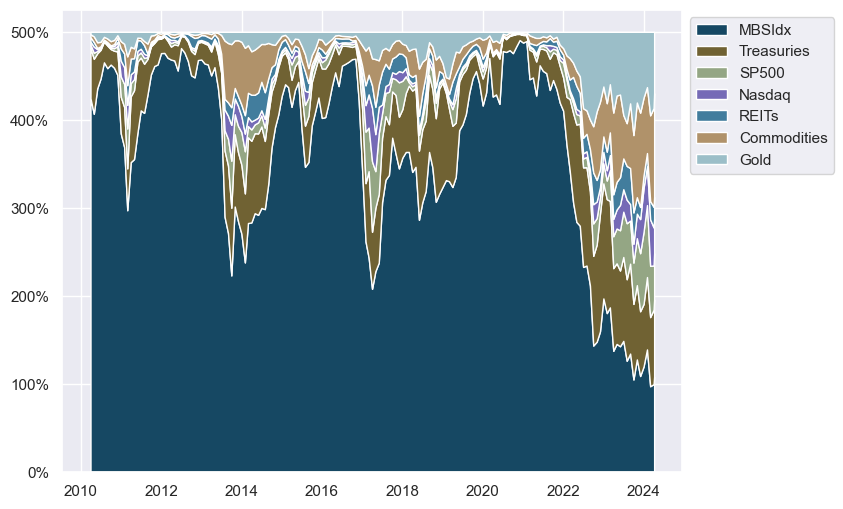

In [ ]:
import quantkit.visualization.asset_allocation.weights as weights

weights.strategy_weights(
    unconstrained_df[
        ["MBSIdx", "Treasuries", "SP500", "Nasdaq", "REITs", "Commodities", "Gold"]
    ]
)

### 2.2 Constrained HRP

In [ ]:
pd.options.display.float_format = "{:.2%}".format
constrained_df = pd.DataFrame(columns=r.portfolio_datasource.all_tickers)
for date, allo in (
    r.strategies["q_alpha"]
    .allocation_engines_d["constrained_hrp"]
    .allocations_history.items()
):
    constrained_df = pd.concat(
        [
            constrained_df,
            pd.DataFrame(
                allo, columns=[date], index=r.portfolio_datasource.all_tickers
            ).transpose(),
        ]
    )

qalpha_cols = {
    "SPXT Index": "SP500",
    "XNDX Index": "Nasdaq",
    "GA10 Index": "Treasuries",
    "LUMSTRUU Index": "MBSIdx",
    "DJUSRET Index": "REITs",
    "BCOMTR Index": "Commodities",
    "GC1 Comdty": "Gold",
}
constrained_df = constrained_df.rename(columns=qalpha_cols)

constrained_df["Sum Risky Assets"] = (
    constrained_df["Commodities"]
    + constrained_df["Gold"]
    + constrained_df["Nasdaq"]
    + constrained_df["REITs"]
    + constrained_df["SP500"]
)
constrained_df["Sum Non-Risky Assets"] = (
    constrained_df["MBSIdx"] + constrained_df["Treasuries"]
)

constrained_df.tail()[
    [
        "Commodities",
        "Gold",
        "MBSIdx",
        "Nasdaq",
        "REITs",
        "SP500",
        "Treasuries",
        "Sum Risky Assets",
        "Sum Non-Risky Assets",
    ]
]

,Commodities,Gold,MBSIdx,Nasdaq,REITs,SP500,Treasuries,Sum Risky Assets,Sum Non-Risky Assets
2023-12-31,40.00%,50.00%,119.69%,77.48%,14.44%,127.42%,70.96%,309.34%,190.66%
2024-01-31,40.00%,50.00%,139.09%,60.54%,15.28%,112.85%,82.24%,278.67%,221.33%
2024-02-29,40.00%,50.00%,118.27%,100.00%,25.31%,70.82%,95.60%,286.13%,213.87%
2024-03-31,40.00%,50.00%,119.82%,100.00%,28.03%,60.51%,101.64%,278.54%,221.46%
2024-04-05,40.00%,50.00%,122.63%,100.00%,28.19%,59.58%,99.60%,277.77%,222.23%


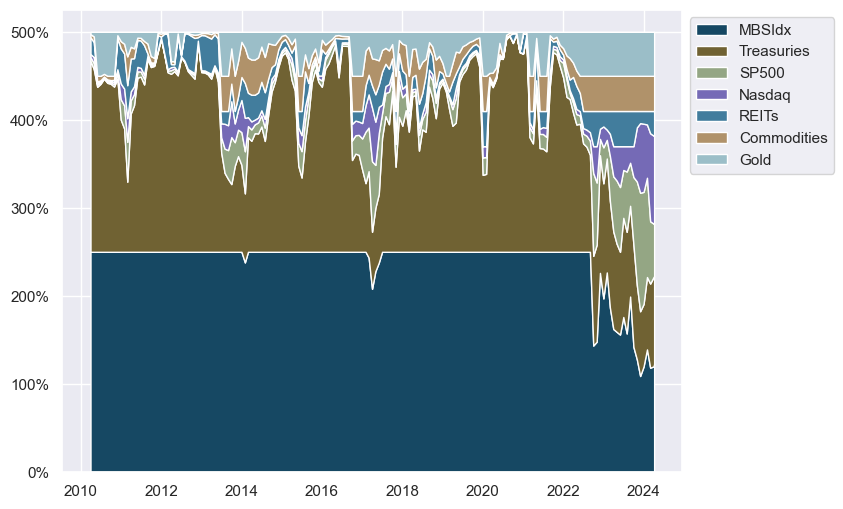

In [ ]:
import quantkit.visualization.asset_allocation.weights as weights

weights.strategy_weights(
    constrained_df[
        ["MBSIdx", "Treasuries", "SP500", "Nasdaq", "REITs", "Commodities", "Gold"]
    ]
)

### 2.3 Scaled HRP

In [ ]:
pd.options.display.float_format = "{:.2%}".format
scaled_df = pd.DataFrame(columns=r.portfolio_datasource.all_tickers)
for date, allo in (
    r.strategies["q_alpha"]
    .allocation_engines_d["scaled_hrp"]
    .allocations_history.items()
):
    scaled_df = pd.concat(
        [
            scaled_df,
            pd.DataFrame(
                allo, columns=[date], index=r.portfolio_datasource.all_tickers
            ).transpose(),
        ]
    )

qalpha_cols = {
    "SPXT Index": "SP500",
    "XNDX Index": "Nasdaq",
    "GA10 Index": "Treasuries",
    "LUMSTRUU Index": "MBSIdx",
    "DJUSRET Index": "REITs",
    "BCOMTR Index": "Commodities",
    "GC1 Comdty": "Gold",
}
scaled_df = scaled_df.rename(columns=qalpha_cols)

scaled_df["Sum Risky Assets"] = (
    scaled_df["Commodities"]
    + scaled_df["Gold"]
    + scaled_df["Nasdaq"]
    + scaled_df["REITs"]
    + scaled_df["SP500"]
)
scaled_df["Sum Non-Risky Assets"] = scaled_df["MBSIdx"] + scaled_df["Treasuries"]

scaled_df.tail()[
    [
        "Commodities",
        "Gold",
        "MBSIdx",
        "Nasdaq",
        "REITs",
        "SP500",
        "Treasuries",
        "Sum Risky Assets",
        "Sum Non-Risky Assets",
    ]
]

,Commodities,Gold,MBSIdx,Nasdaq,REITs,SP500,Treasuries,Sum Risky Assets,Sum Non-Risky Assets
2023-12-31,18.10%,22.63%,250.00%,35.06%,6.54%,57.67%,110.00%,140.00%,360.00%
2024-01-31,20.10%,25.12%,250.00%,30.41%,7.68%,56.70%,110.00%,140.00%,360.00%
2024-02-29,19.57%,24.46%,250.00%,48.93%,12.38%,34.65%,110.00%,140.00%,360.00%
2024-03-31,20.10%,25.13%,250.00%,50.26%,14.09%,30.41%,110.00%,140.00%,360.00%
2024-04-05,20.16%,25.20%,250.00%,50.40%,14.21%,30.03%,110.00%,140.00%,360.00%


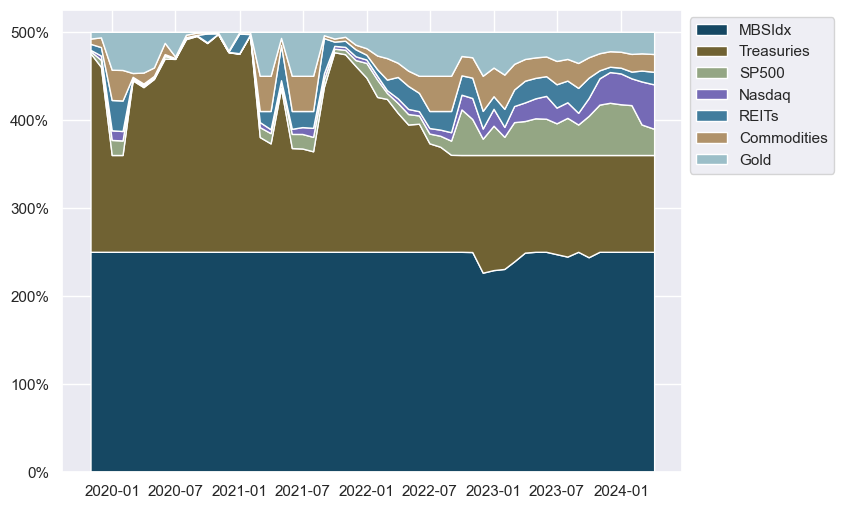

In [ ]:
import quantkit.visualization.asset_allocation.weights as weights

scaled_df = scaled_df[scaled_df.index > "2019-10-01"]

weights.strategy_weights(
    scaled_df[
        ["MBSIdx", "Treasuries", "SP500", "Nasdaq", "REITs", "Commodities", "Gold"]
    ]
)

## Q-Gov

In [ ]:
# import quantkit.visualization.asset_allocation.weights as weights


# or_df = pd.DataFrame(columns=r.portfolio_datasource.all_tickers)
# for date, allo in r.strategies["q_alpha"].allocation_engines_d["original_weight"].allocations_history.items():
#     or_df = pd.concat([or_df, pd.DataFrame(allo, columns=[date], index=r.portfolio_datasource.all_tickers).transpose()])

# or_df = or_df[or_df.index > "2019-10-01"]
# weights.strategy_weights(or_df[["MBSIdx", "Treasuries", "SP500", "Nasdaq", "REITs", "Commodities", "Gold"]])

# Load Data

In [ ]:
# import pandas as pd

# ld_data = pd.read_csv("J:\ML-Select\TCW ML-Select Levered Diversification\Mohit\python\LD\data\LDmodelData.csv")
# ld_data["date"] = pd.to_datetime(ld_data["date"])
# ld_data = ld_data.melt(id_vars=["date"],
#         var_name="ticker",
#         value_name="closeadj")
# ld_data = ld_data.sort_values(by=["date", "ticker"])

In [ ]:
# import pandas as pd
# import numpy as np

# target = pd.read_excel("Q_Alpha_Output//target_qalpha.xlsx")
# target = target.drop(['Non -Risk', 'Total', 'Risk'], axis=1)
# target = target.melt(id_vars=["Month"], value_name="Portfolio_Weight", var_name="ISIN")
# target["Month"] = pd.to_datetime(target["Month"])
# target = target.sort_values(["Month", "ISIN"])
# target = target.rename(columns={"Month": "As Of Date"})
# target["Portfolio_Weight"] = target["Portfolio_Weight"] / 5

# target["Portfolio"] = "Q-Alpha"
# target["Portfolio_Name"] = "Q-Alpha"
# target["ESG Collateral Type"] = np.nan
# target["Issuer ESG"] = np.nan
# target["Loan Category"] = np.nan
# target["Labeled ESG Type"] = np.nan
# target["Security_Name"] = target["ISIN"]
# target["TCW ESG"] = np.nan
# target["Ticker Cd"] = target["ISIN"]
# target["Sector Level 1"] = np.nan
# target["Sector Level 2"] = np.nan
# target["JPM Sector"] = np.nan
# target["BCLASS_Level2"] = np.nan
# target["BCLASS_Level3"] = np.nan
# target["BCLASS_Level4"] = np.nan
# target["Country of Risk"] = np.nan
# target["MSCI ISSUERID"] = np.nan
# target["ISS ISSUERID"] = np.nan
# target["BBG ISSUERID"] = np.nan
# target["Base Mkt Val"] = np.nan
# target["OAS"] = np.nan
# target["Issuer ISIN"] = target["ISIN"]

# target.to_excel("Q_Alpha_Output//Q_Alpha_historical_weights.xlsx", index=False)